In [88]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.size'] = 14
plt.rcParams['lines.markersize'] = 6

# 忽略warning
warnings.filterwarnings("ignore")

In [89]:
data = pd.read_csv('data/history.csv', dtype={'CustomerID': str, 'InvoiceID': str})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389168 entries, 0 to 389167
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    389168 non-null  object 
 1   StockCode    389168 non-null  object 
 2   Description  389168 non-null  object 
 3   Quantity     389168 non-null  int64  
 4   InvoiceDate  389168 non-null  object 
 5   UnitPrice    389168 non-null  float64
 6   CustomerID   389168 non-null  object 
 7   Country      389168 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 23.8+ MB


In [90]:
# 处理重复值
data = data.drop_duplicates()
# 数据升维
data["Total"] = data["Quantity"] * data["UnitPrice"]
data[["Date", "Time"]] = data["InvoiceDate"].str.split(" ", expand=True)
data[["Month", "Day", "Year"]] = data["Date"].str.split("-", expand=True)
data["Hour"] = data["Time"].str.split(":", expand=True)[0].astype("int")
data.describe()

,Quantity,UnitPrice,Total,Hour
count,384222.000000,384222.000000,384222.000000,384222.000000
mean,12.205545,3.502443,20.657276,12.718569
std,176.786144,71.249977,213.457124,2.279166
min,-74215.000000,0.000000,-77183.600000,6.000000
25%,2.000000,1.250000,4.250000,11.000000
50%,5.000000,1.950000,11.700000,13.000000
75%,12.000000,3.750000,19.800000,14.000000
max,74215.000000,38970.000000,77183.600000,20.000000


In [91]:
# 筛选有效商品
data['is_product_valid'] = data['StockCode'].str.match('[0-9].*')

data_buy = data[(data["Quantity"] >= 0) & (data['is_product_valid'] == True)]
data_return = data[(data["Quantity"] < 0) & (data['is_product_valid'] == True)]

In [92]:
data_buy['StockCode'] = list(map(lambda x: x[:5],data_buy['StockCode']))
data_return['StockCode'] = list(map(lambda x: x[:5],data_return['StockCode']))
data_buy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Date,Time,Month,Day,Year,Hour,is_product_valid
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,08:26:00,2010,12,01,8,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00,2010,12,01,8,True
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,08:26:00,2010,12,01,8,True
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00,2010,12,01,8,True
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00,2010,12,01,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389148,579885,85034,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444,United Kingdom,5.00,2011-11-30,17:37:00,2011,11,30,17,True
389149,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444,United Kingdom,11.90,2011-11-30,17:37:00,2011,11,30,17,True
389150,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444,United Kingdom,12.48,2011-11-30,17:37:00,2011,11,30,17,True
389151,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444,United Kingdom,7.95,2011-11-30,17:37:00,2011,11,30,17,True


## 商品聚类分析

In [93]:
product_data = pd.DataFrame()
product_data['StockCode'] = data_buy['StockCode'].drop_duplicates().sort_values()
product_data.reset_index(drop=True)
product_data['quantity_buy'] = data_buy["Quantity"].groupby(data_buy["StockCode"]).sum().values

product_quantity_return = data_return["Quantity"].groupby(data_return["StockCode"]).sum()
product_quantity_return = pd.DataFrame(product_quantity_return).rename(columns={'Quantity': 'quantity_return'})
product_data = product_data.merge(product_quantity_return, on='StockCode', how='left')

product_data['quantity_return'] = product_data['quantity_return'].fillna(0).astype(int)
product_data['sold_times'] = data_buy["CustomerID"].groupby(data_buy["StockCode"]).count().values

customer_count = data_buy.loc[:, ['StockCode', 'CustomerID']] \
    .drop_duplicates(subset=['StockCode', 'CustomerID']) \
    .sort_values(by='StockCode') \
    .groupby('StockCode') \
    .count().values
product_data['customer_count'] = customer_count

unit_price = data_buy.loc[:, ['StockCode', 'UnitPrice']] \
    .drop_duplicates(subset=['StockCode']) \
    .sort_values(by='UnitPrice', ascending=False)
product_data = product_data.merge(unit_price, on='StockCode', how='left').rename(columns={'UnitPrice': 'unit_price'})

product_data['return_rate'] = abs(product_data['quantity_return'] / product_data['quantity_buy']) * 100
product_data = product_data[(product_data['return_rate'] >= 0) & (product_data['return_rate'] <= 100)]
product_data['quantity_real'] = product_data['quantity_buy'] + product_data['quantity_return']
product_data['sales_total'] = product_data['unit_price'] * product_data['quantity_real']
product_data = product_data.drop(axis=True, labels=['quantity_buy', 'quantity_return', 'unit_price'])
product_data.describe()

,sold_times,customer_count,return_rate,quantity_real,sales_total
count,3184.000000,3184.000000,3184.000000,3184.000000,3184.000000
mean,117.437186,79.021671,2.772528,1472.347048,2698.555371
std,171.735370,93.289276,8.912002,3180.507696,6053.979913
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,18.000000,15.000000,0.000000,98.000000,227.355000
50%,60.000000,48.000000,0.237969,483.500000,954.925000
75%,147.000000,108.000000,1.787978,1559.000000,2685.600000
max,2851.000000,873.000000,100.000000,72418.000000,141215.100000


In [94]:
product_data = product_data[product_data['quantity_real'] >= 100]
product_data

,StockCode,sold_times,customer_count,return_rate,quantity_real,sales_total
0,10002,49,40,0.000000,823,699.55
1,10080,21,19,0.000000,291,247.35
2,10120,28,25,0.000000,186,39.06
5,10125,61,48,0.000000,1199,1019.15
6,10133,122,101,0.421408,2363,2008.55
...,...,...,...,...,...,...
3179,90200,81,28,0.393701,253,1075.25
3180,90201,41,16,8.374384,186,548.70
3186,90209,28,10,2.147971,410,861.00
3187,90210,16,9,0.000000,234,690.30


In [95]:
product_tmp = MinMaxScaler().fit_transform(product_data.iloc[:, 1:])
product_tmp = pd.DataFrame(product_tmp)
product_tmp.columns = product_data.columns[1:]

In [96]:
feature_columns = product_tmp.columns.tolist()[:]
feature_columns

['sold_times', 'customer_count', 'return_rate', 'quantity_real', 'sales_total']

In [97]:
plt.rcParams['font.size'] = 14
plt.rcParams['lines.markersize'] = 6
axes = scatter_matrix(
    product_tmp[feature_columns],
    diagonal='hist',
    figsize=(12, 12)
)
plt.subplots_adjust(left=0.06, right=0.98, top=0.98, bottom=0.06)
plt.savefig('imgs/01_product_data_scatter_matrix.svg', format='svg')
# plt.savefig('imgs/01_product_data_scatter_matrix.png', format='png')

In [98]:
product_data_corr = product_tmp[feature_columns].corr()
product_data_corr

,sold_times,customer_count,return_rate,quantity_real,sales_total
sold_times,1.000000,0.949982,-0.001592,0.752240,0.845922
customer_count,0.949982,1.000000,-0.006386,0.679814,0.757345
return_rate,-0.001592,-0.006386,1.000000,-0.024744,0.030451
quantity_real,0.752240,0.679814,-0.024744,1.000000,0.693322
sales_total,0.845922,0.757345,0.030451,0.693322,1.000000


In [99]:
from sklearn.decomposition import PCA

pca_2 = PCA(n_components=5)
data_pca_2 = pd.DataFrame(pca_2.fit_transform(product_tmp[feature_columns]))

from sklearn.cluster import KMeans

clusters = 4
km_model = KMeans(n_clusters=clusters)
km_model = km_model.fit(product_tmp[feature_columns])
p_target = km_model.predict(product_tmp[feature_columns])

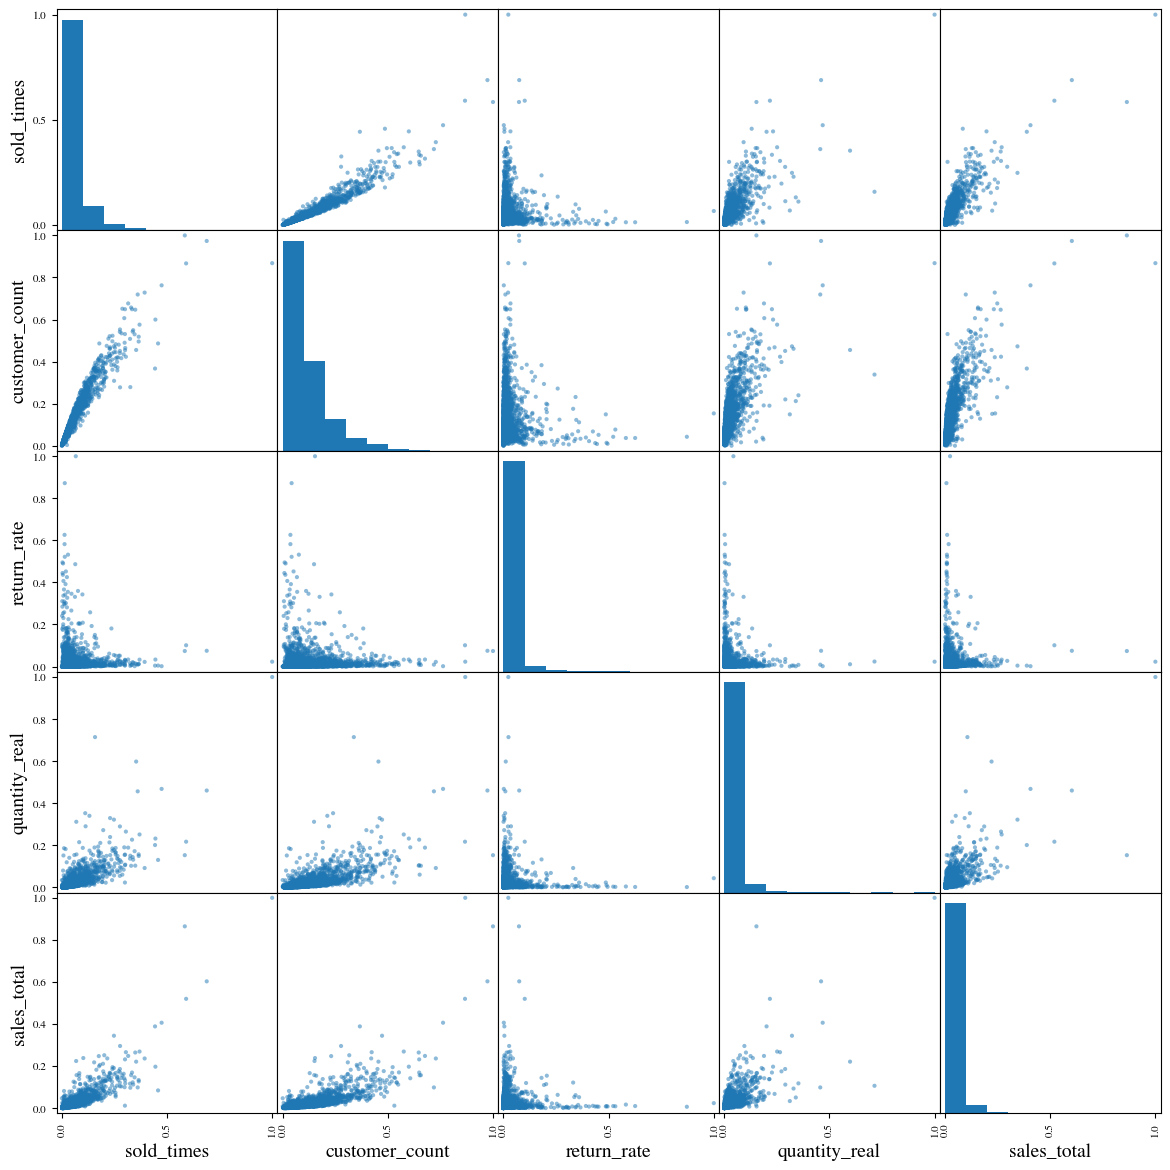

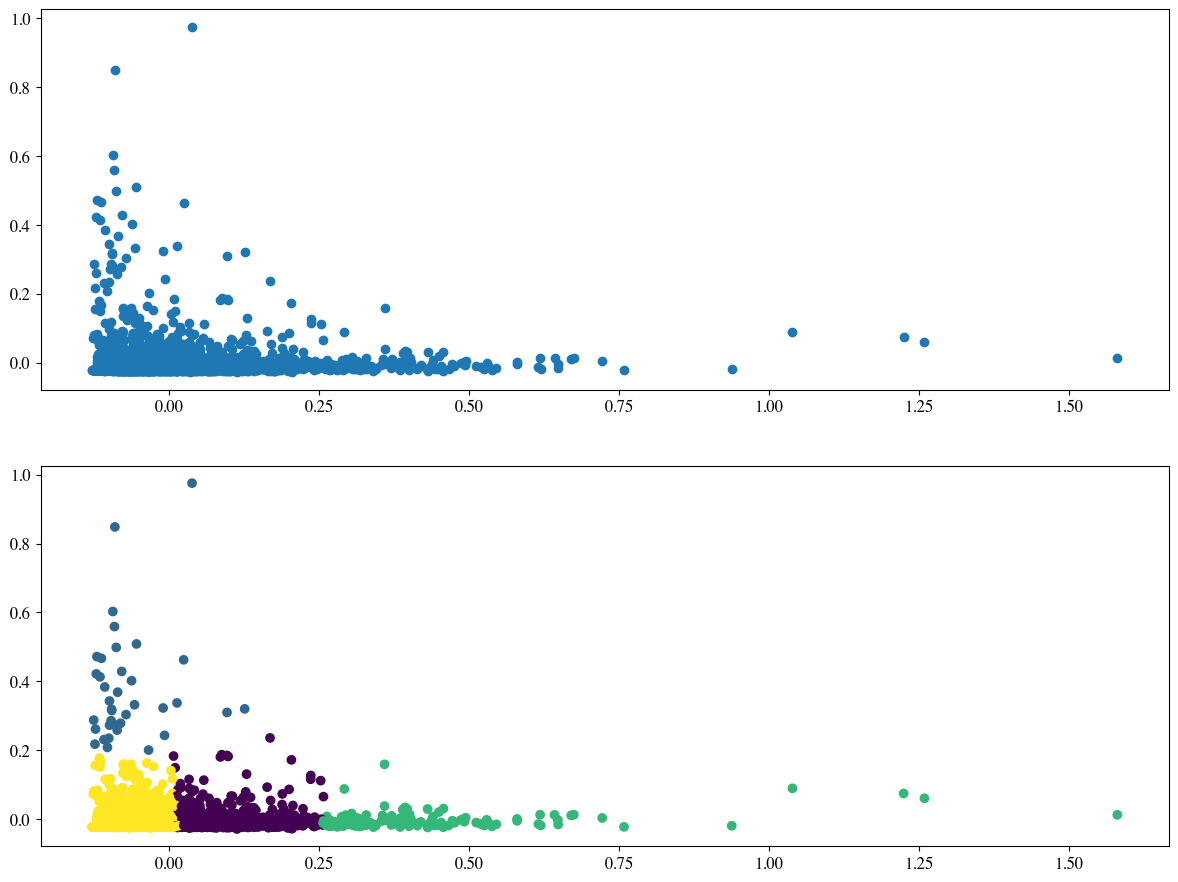

In [100]:
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 6
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 1)
plt.scatter(
    data_pca_2[0],
    data_pca_2[1]
)

plt.subplot(2, 1, 2)
figure = plt.scatter(
    data_pca_2[0],
    data_pca_2[1],
    c=p_target
)
plt.subplots_adjust(left=0.04, right=0.98, top=0.98, bottom=0.05)
plt.savefig('imgs/02_product_data_scatter.svg', format='svg')
# plt.savefig('imgs/02_product_data_scatter.png', format='png')
plt.show()
# plt.savefig('imgs/02_product_data_scatter_origin.svg', format='svg')
# plt.savefig('imgs/03_product_data_scatter_matrix_clusters.svg', format='svg')

In [101]:
product_result = product_data.copy()
product_result['unit_price'] = product_result['sales_total'] / product_result['quantity_real']
product_result['cluster'] = p_target
product_result.describe()

,sold_times,customer_count,return_rate,quantity_real,sales_total,unit_price,cluster
count,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000
mean,153.344379,102.585151,2.200616,1954.949664,3538.219367,2.699841,2.162752
std,185.011393,96.910077,5.708503,3547.385004,6781.006556,3.049405,1.291512
min,2.000000,1.000000,0.000000,100.000000,22.800000,0.070000,0.000000
25%,46.000000,37.000000,0.000000,342.750000,687.817500,0.850000,0.750000
50%,93.500000,72.000000,0.532703,885.500000,1528.360000,1.650000,3.000000
75%,187.250000,137.000000,2.007982,2052.000000,3746.135000,3.015000,3.000000
max,2851.000000,873.000000,95.838104,72418.000000,141215.100000,49.950000,3.000000


In [102]:
pd.DataFrame({'amount': product_data['StockCode'].groupby(product_result['cluster']).count()})

,amount
cluster,
0,596
1,37
2,134
3,1617


In [103]:
product_result[product_result['cluster'] == 0].describe()

,sold_times,customer_count,return_rate,quantity_real,sales_total,unit_price,cluster
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.0
mean,257.337248,174.998322,2.005624,3166.598993,5703.040050,2.805839,0.0
std,84.523749,46.137263,3.186032,2805.426785,4300.199703,2.665427,0.0
min,130.000000,103.000000,0.000000,414.000000,827.080000,0.100000,0.0
25%,190.000000,138.000000,0.326270,1501.750000,2899.470000,1.250000,0.0
50%,239.000000,166.000000,0.892649,2390.500000,4679.075000,1.950000,0.0
75%,310.250000,204.000000,2.371810,3973.000000,7051.875000,3.750000,0.0
max,575.000000,323.000000,24.694903,25589.000000,34941.540000,14.950000,0.0


In [104]:
product_result[product_result['cluster'] == 1].describe()

,sold_times,customer_count,return_rate,quantity_real,sales_total,unit_price,cluster
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0
mean,67.081081,50.486486,38.396674,916.540541,2180.452973,4.612432,1.0
std,66.580101,46.417562,15.793176,1414.281435,3225.702823,8.165504,0.0
min,5.000000,5.000000,21.576570,111.000000,67.200000,0.140000,1.0
25%,22.000000,20.000000,28.685259,237.000000,704.760000,1.250000,1.0
50%,41.000000,35.000000,33.163265,382.000000,1130.500000,2.550000,1.0
75%,83.000000,61.000000,43.323442,813.000000,1821.600000,4.650000,1.0
max,280.000000,203.000000,95.838104,6734.000000,17171.700000,49.950000,1.0


In [105]:
product_result[product_result['cluster'] == 2].describe()

,sold_times,customer_count,return_rate,quantity_real,sales_total,unit_price,cluster
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.0
mean,720.141791,387.082090,1.799807,10363.686567,20692.059328,2.552836,2.0
std,316.760343,113.214285,2.196526,9145.963138,18459.946101,1.937899,0.0
min,418.000000,243.000000,0.071922,1693.000000,1653.950000,0.290000,2.0
25%,532.000000,316.250000,0.564156,5594.250000,10977.750000,1.250000,2.0
50%,644.500000,358.500000,1.147186,7780.000000,17222.250000,1.950000,2.0
75%,802.750000,421.500000,2.209468,11678.750000,23357.100000,2.950000,2.0
max,2851.000000,873.000000,17.331170,72418.000000,141215.100000,10.950000,2.0


In [106]:
product_result[product_result['cluster'] == 3].describe()

,sold_times,customer_count,return_rate,quantity_real,sales_total,unit_price,cluster
count,1617.000000,1617.000000,1617.000000,1617.000000,1617.000000,1617.000000,1617.0
mean,70.017934,53.510823,1.477468,835.288188,1349.839450,2.629190,3.0
std,41.745060,29.070183,2.795487,1022.825982,1325.792603,3.034377,0.0
min,2.000000,1.000000,0.000000,100.000000,22.800000,0.070000,3.0
25%,36.000000,29.000000,0.000000,246.000000,497.250000,0.850000,3.0
50%,63.000000,50.000000,0.161031,519.000000,966.000000,1.650000,3.0
75%,99.000000,76.000000,1.673102,1082.000000,1762.740000,2.950000,3.0
max,254.000000,122.000000,19.215686,13547.000000,11514.950000,34.950000,3.0


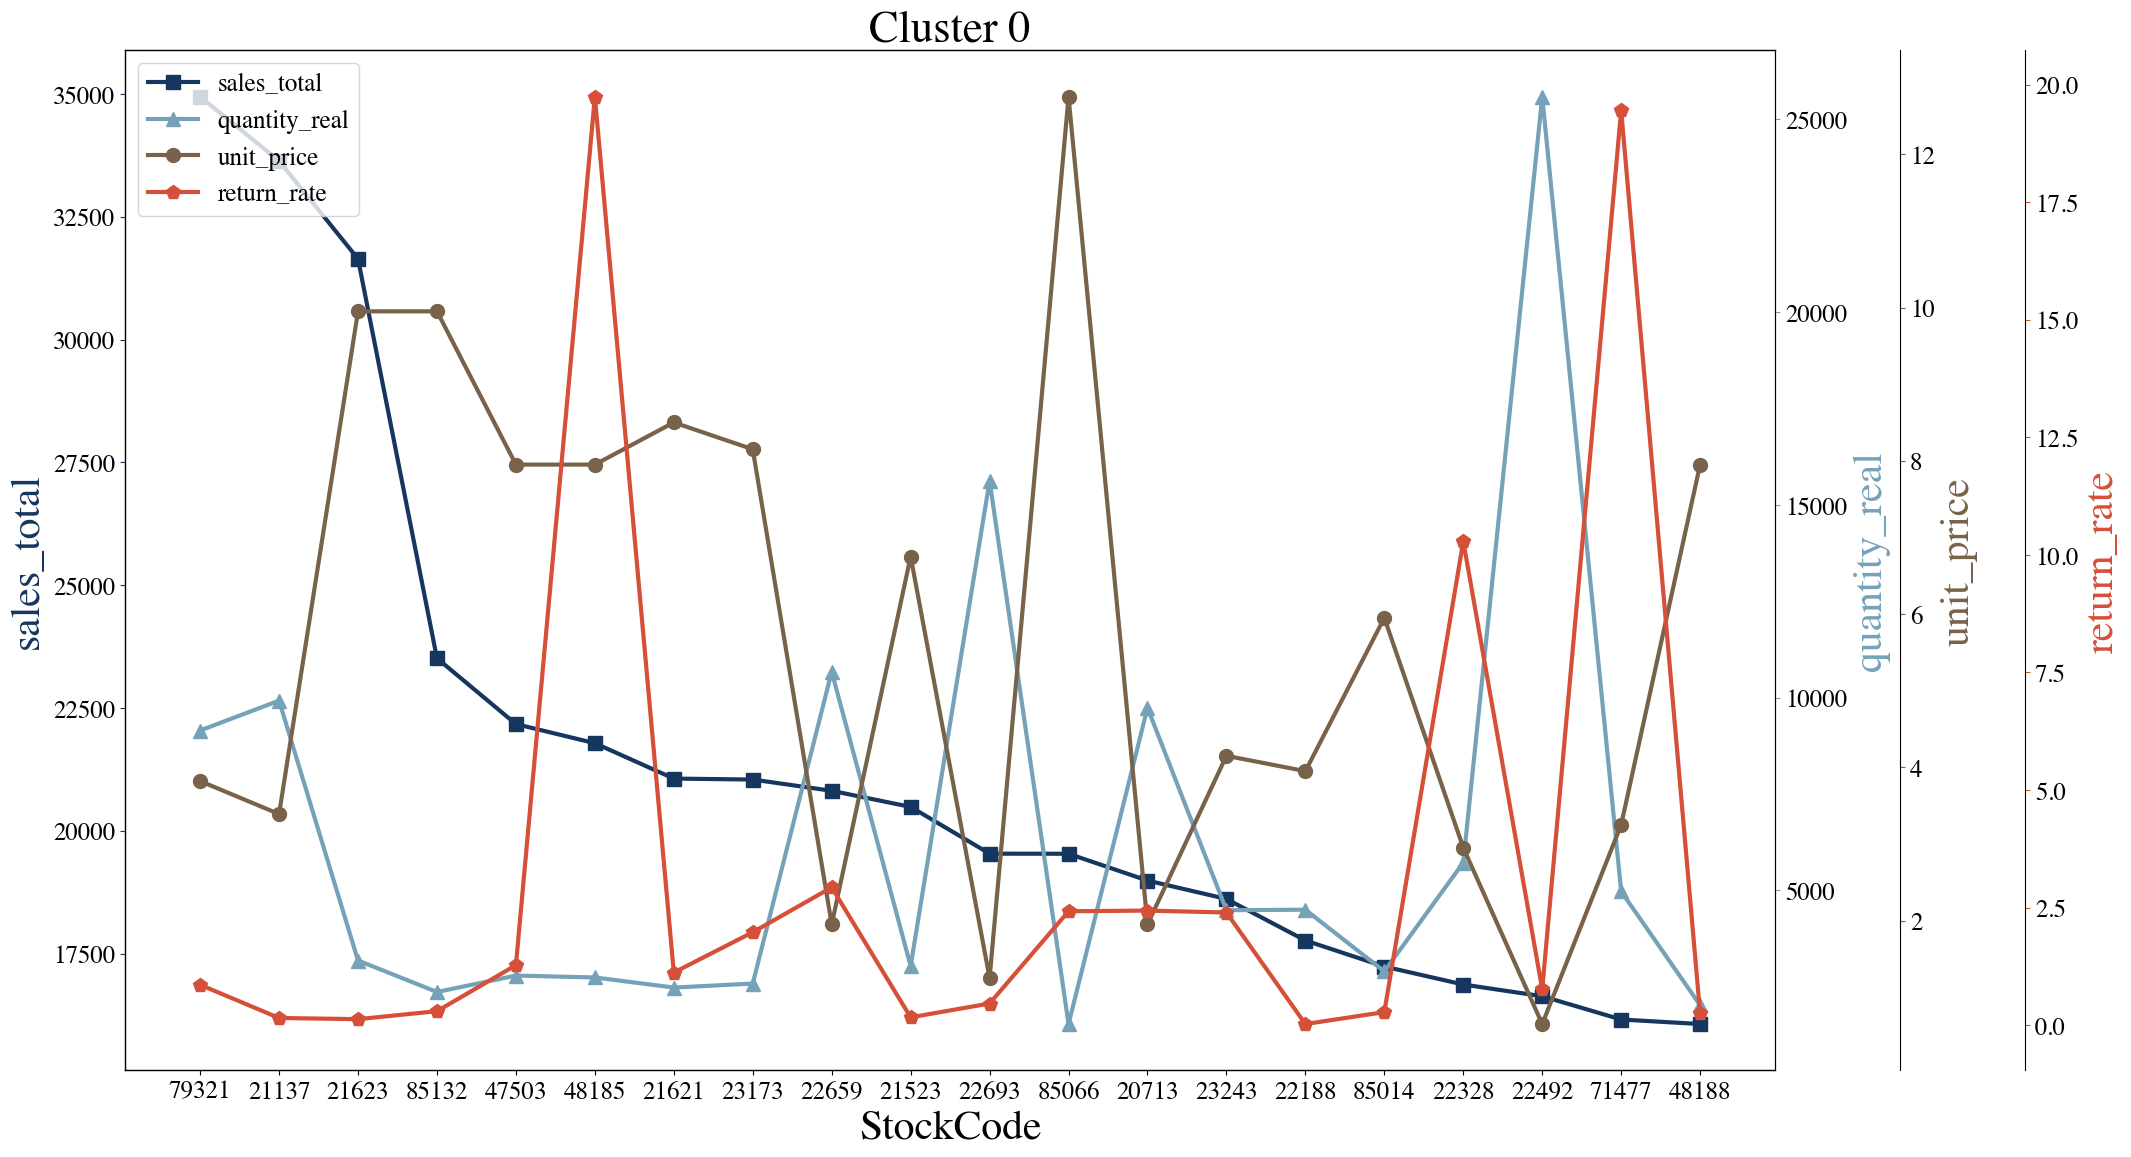

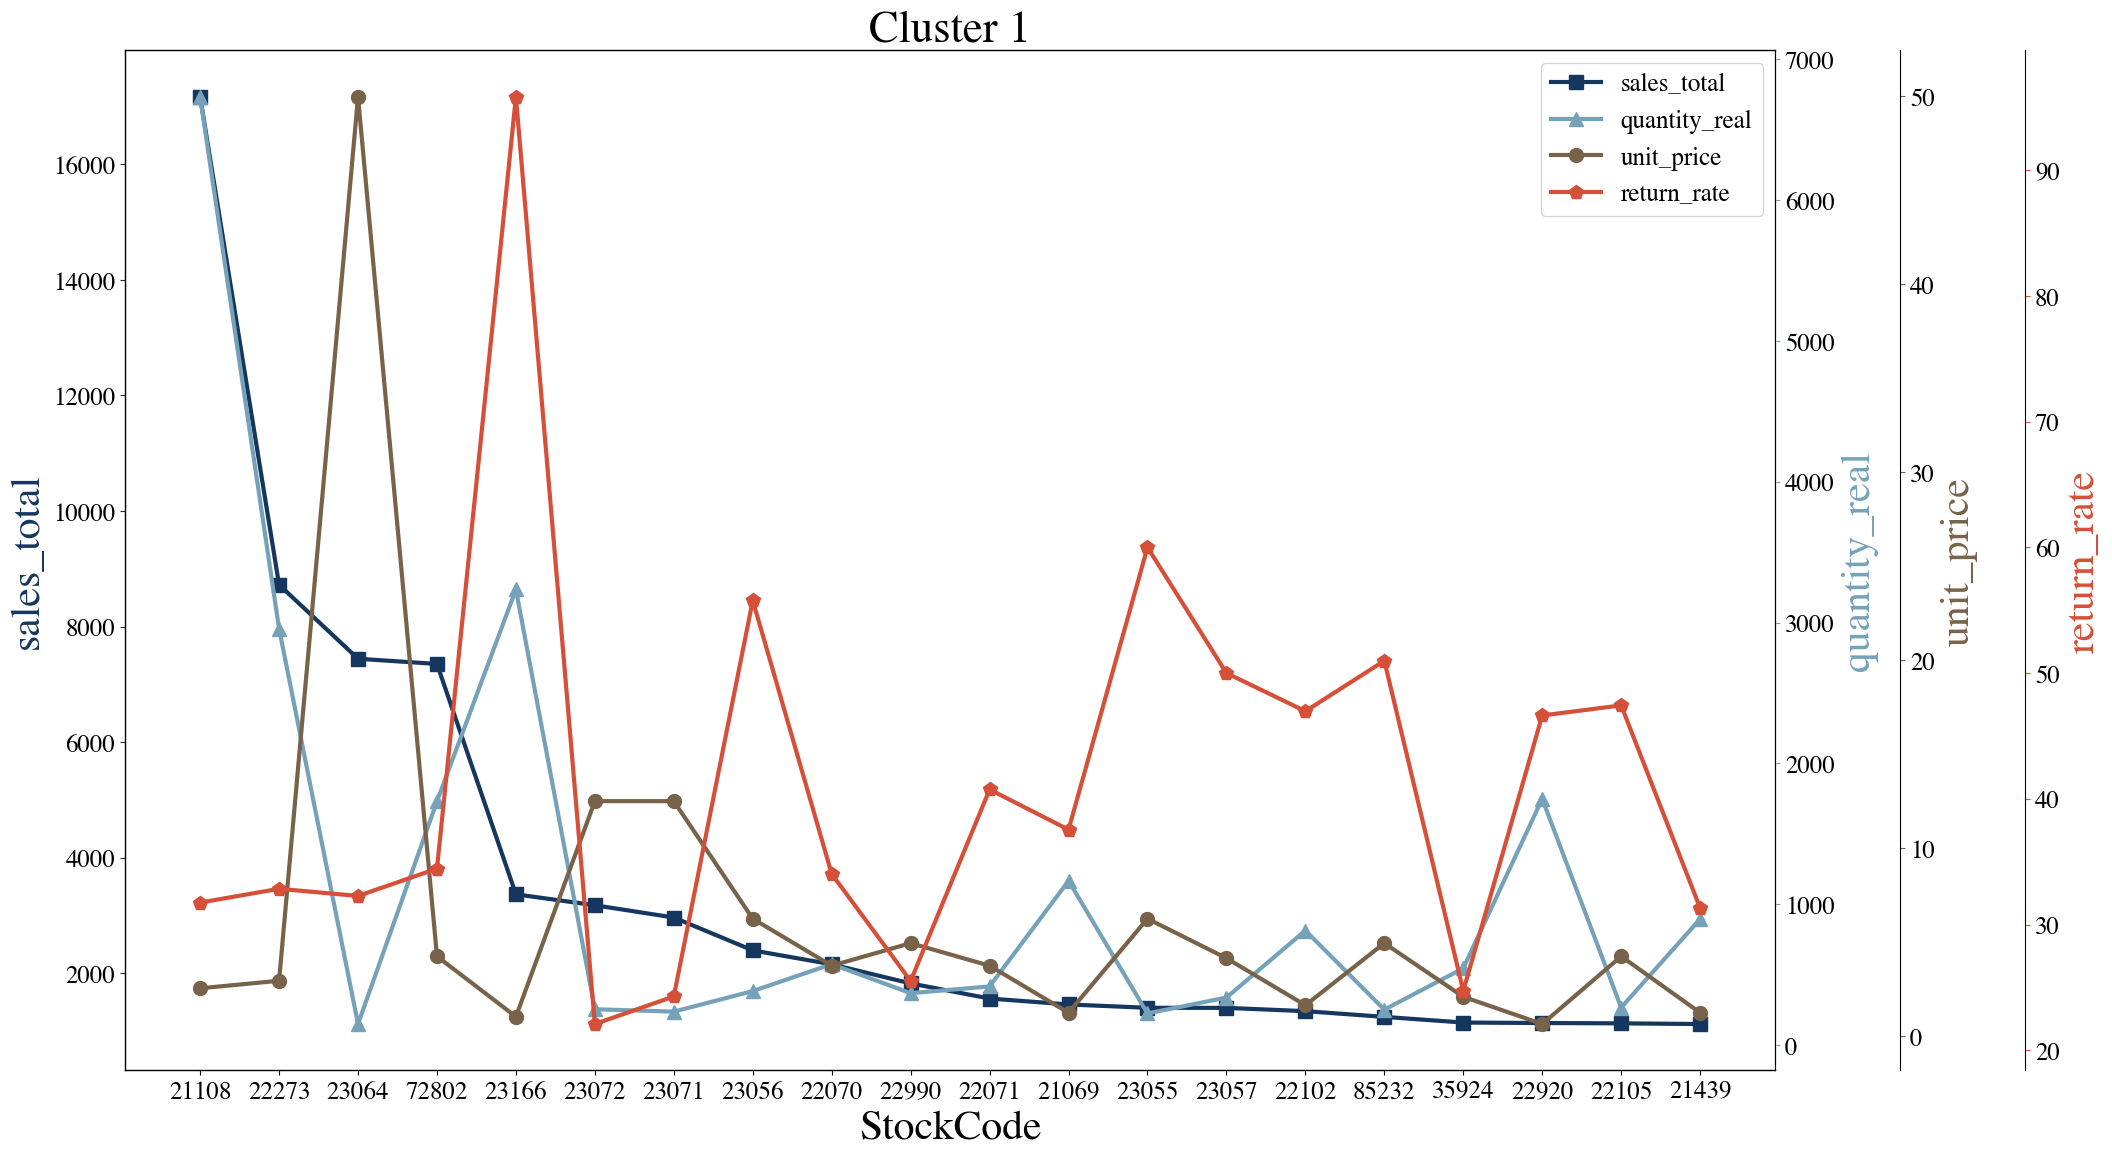

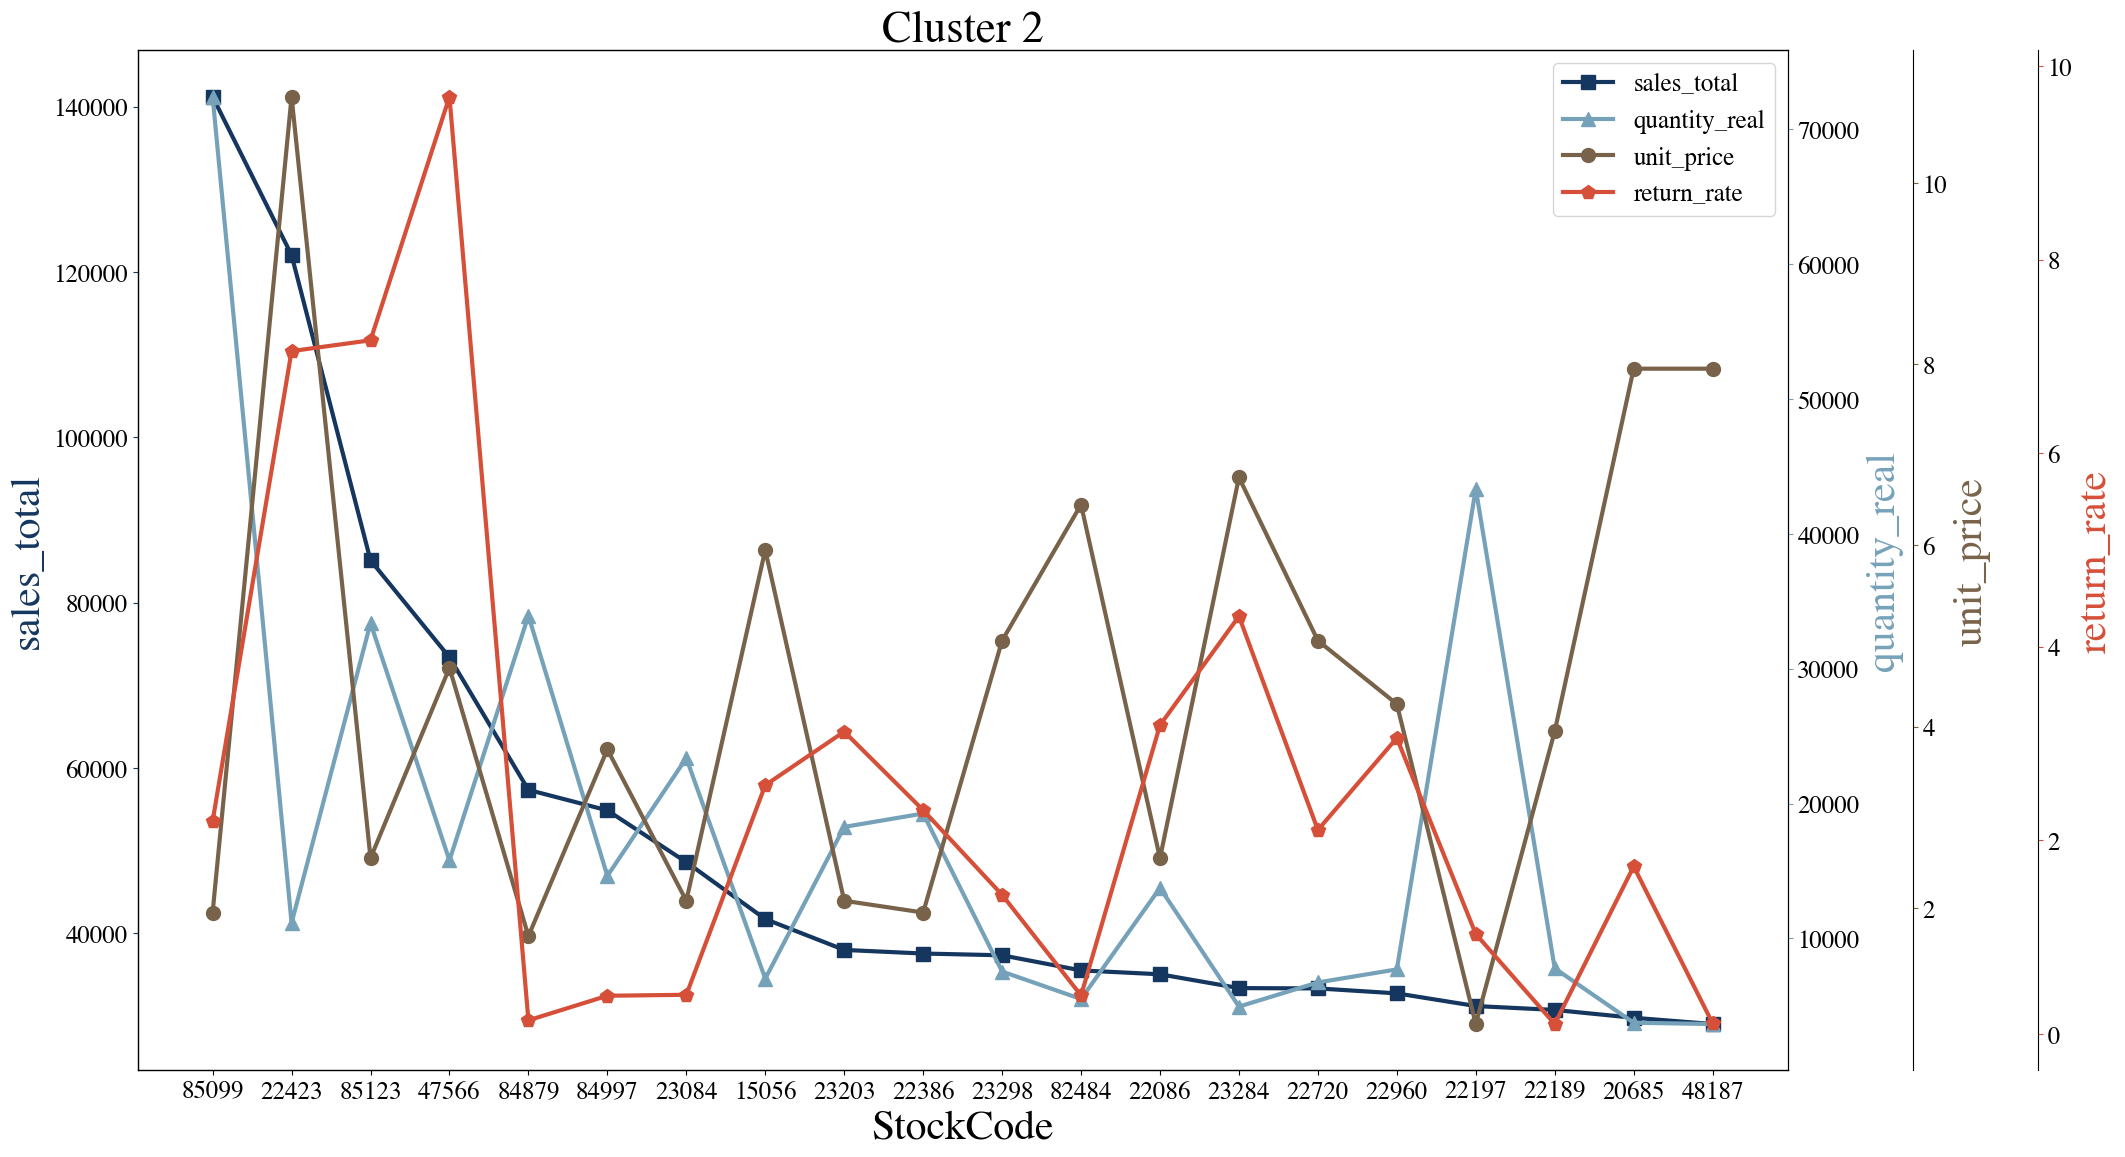

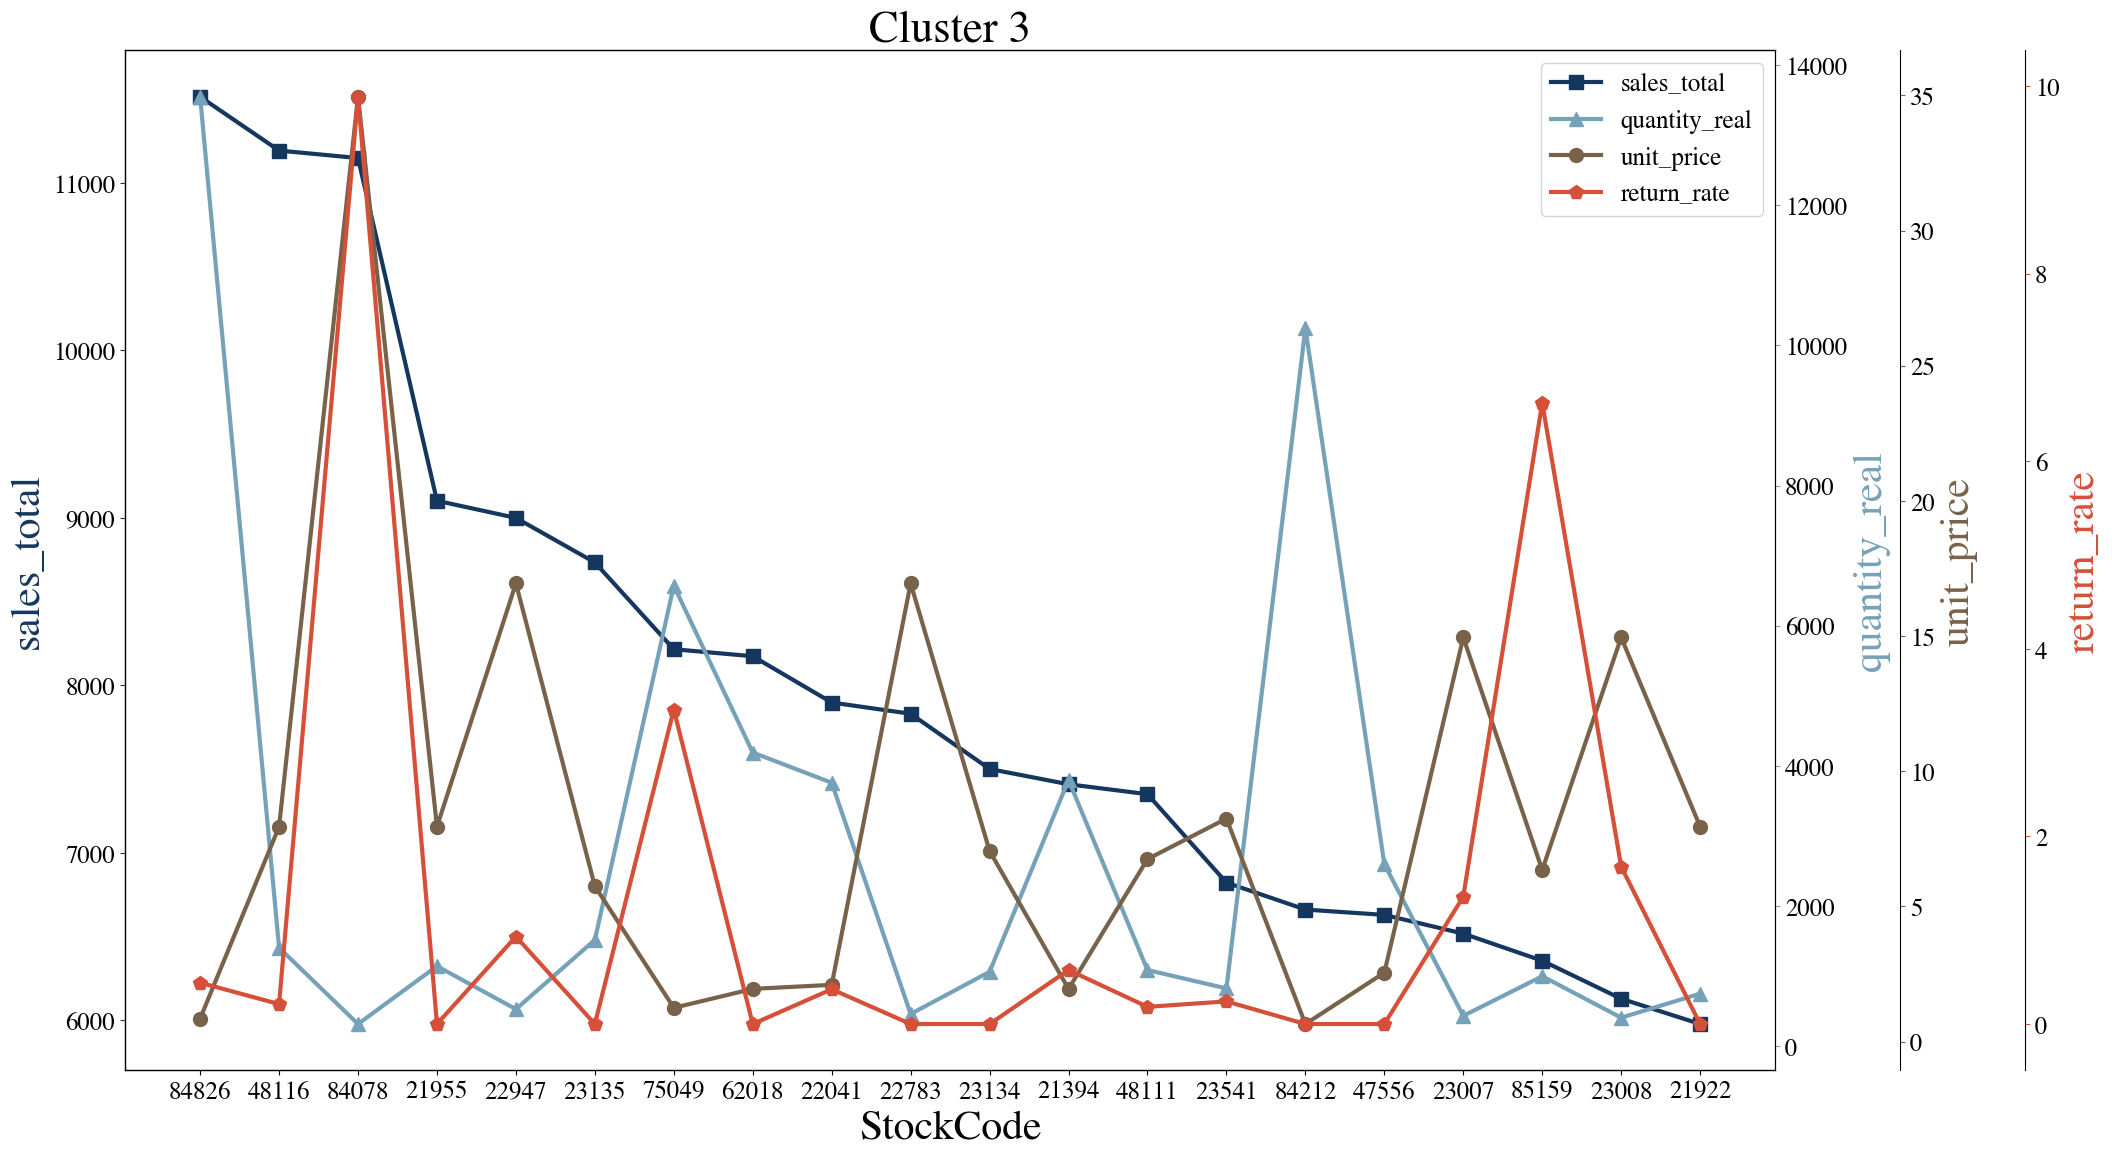

In [107]:
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10

title_size = 32
label_size = 30
# plt.rcParams['figure.subplot.right'] = 0.8

for c in range(0, clusters)[:]:
    # 取销售额前20的商品可视化分析
    tmp = product_result[product_result['cluster'] == c] \
        .reset_index(drop=True) \
        .sort_values(by=['sales_total'], ascending=False) \
        .head(20)
    fig, ax1 = plt.subplots(figsize=(22, 12))
    plt.title('Cluster {}'.format(c), size=title_size)
    colors = ['#14365F', '#76A2B9', '#78634A', '#D64F38']
    # 销售额
    ax1.plot(tmp['StockCode'], tmp['sales_total'], 's-', label='sales_total', color=colors[0])
    ax1.set_xlabel('StockCode', size=label_size)
    ax1.set_ylabel('sales_total', color=colors[0], size=label_size)
    ax1.tick_params('y', color=colors[0])
    # 销售量
    ax2 = ax1.twinx()
    ax2.plot(tmp['StockCode'], tmp['quantity_real'], '^-', label='quantity_real', color=colors[1])
    ax2.set_ylabel('quantity_real', color=colors[1], size=label_size)
    ax2.tick_params('y', color=colors[1])
    # 单价
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 90))
    ax3.plot(tmp['StockCode'], tmp['unit_price'], 'o-', label='unit_price', color=colors[2])
    ax3.set_ylabel('unit_price', color=colors[2], size=label_size)
    ax3.tick_params('y', color=colors[2])
    # 退货率
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 180))
    ax4.plot(tmp['StockCode'], tmp['return_rate'], 'p-', label='return_rate', color=colors[3])
    ax4.set_ylabel('return_rate', color=colors[3], size=label_size)
    ax4.tick_params('y', color=colors[3])
    # 添加图例
    lines = [ax1.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0], ax4.get_lines()[0]]
    plt.legend(lines, [line.get_label() for line in lines])

    # ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    ax4.grid(False)
    plt.subplots_adjust(left=0.07, right=0.82, top=0.93, bottom=0.08)
    plt.savefig('imgs/0{}_product_cluster_{}.svg'.format(c + 3, c), format='svg')
    # plt.savefig('imgs/0{}_product_cluster_{}.png'.format(c + 3, c), format='png')
    plt.show()


In [108]:
# product_result.to_csv('result_05230724.csv')